# Contents

<h4>1) Basecode</h4>
<h4>2) PRM tune for maximum power</h4>
<h4>3) LSC using Decoupling Slope Method</h4>
<h4>4) LSC using Maximum Slope Method</h4>
<h4>5) ASC sensing matrix</h4>
<h4>6) Diagonalisation of ASC matrix</h4>

In [1]:
from pykat import finesse 
       
from pykat.commands import *     
import numpy as np               
import matplotlib.pyplot as plt  
import scipy                     
from IPython import display
from scipy.signal import find_peaks 

              

pykat.init_pykat_plotting(dpi=200)

kat=finesse.kat()
kat.verbose=1


                                              ..-
    PyKat 1.2.81          _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



<h2>BASECODE</h2>

In [2]:
kat.parse("""

l laser 0.08 0 n1                          #laser 30W
maxtem 3
s gap01 1 n1 n2                         #space b/w mod and laser  
mod eom1 $sb1 0.18 3 pm n2 n3         #modulator PM $sb1 3f
s gap02 0.5 n3 n31a                     #space b/w mod and PRM      


##### FOR ANGULAR SENSING PRM #####
bs pickoff 0.0001 0.9999 0 45 n31a dump n32 refl_a
s s2 0.1 refl_a a8                       
bs bsQPD 0.5 0.5 0 45 a8 a9 a10 dump            #bs to split power between two detectors 

s sQPD1 0.1 a9 a11                   
s sQPD2 0.1 a10 a12
#########################



##### FOR ANGULAR SENSING ITM/ETM #####
s sr 0.01 bs12tr n12a    
#bs pickoff1 0.0001 0.9999 0 45 n12a dump dump refl_itm
#s s21 0.1 refl_itm a81                       
bs bsQPD1 0.5 0.5 0 45 n12a a91 a101 dump            #bs to split power between two detectors 

s sQPD11 0.1 a91 a11a                   
s sQPD21 0.1 a101 a12a
#########################



####### 3 m setup ###########

s gap03 0.5 n32 refl

m PRM 0.859 0.1 0 refl pop               #PRM                ---> POP <---

##### folding mirrors #####
s prc 0.5 pop bs1a
bs bs1 0.999 0.001 0 0 bs1a bs12 bs12tr dump
s b1 0.350 bs12 bs21
bs bs2 0.999 0.001 0 0 bs21 bs21a bs21tr dump
s b2 0.5 bs21a b3    
###########################

#m PRM 0 1 90 refl pop               #PRM
#s PRC 1.33 pop b3                        #PRC 
m ITM 0.98997 0.01 0 b3 n12              #ITM
s ARM 3.3 n12 b5                        #ARM length 3.3 (0.01 from sr length) 
m ETM 0.99996 0.00001 0 b5 b6           #ETM
#m ETM 0 1 0 b5 b6 

################################


cav ARML ITM n12 ETM b5 
cav PRCL PRM pop ITM b3


##### attr for TM ######
attr ETM Rc 11.3            # RoC of ETM
attr PRM Rc -23.6           # RoC of PRM
attr PRM xbeta 0            # misalgnment PRM
attr ETM xbeta 0            # misalgnment ETM
attr ITM xbeta 0            # misalgnment ITM
######################


#trace 2 
#phase 2

const sb1 55.556M
const sb2 111.112M
const sb3 166.668M


""")


In [3]:
#### DC PDs ##########

kat_dc = kat.deepcopy()
kat_dc.parse("""

pd circ_arm b5
pd circ_prc pop
pd refl refl
pd trans b6


xaxis PRM phi lin 10 140 8000


""")

<h2>PRM tune for maximum power</h2>

--------------------------------------------------------------
Running kat - Started at 2022-12-07 19:47:38.156444


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse None at C:\Users\Parivesh\anaconda3\Library\bin\kat.exe

Finished in 16.6098 seconds

--- Output info ---

Run date and time: 2022-12-07 19:47:38.163332
Detectors used: circ_arm, circ_prc, refl, trans

One xaxis used: ['xaxis PRM phi lin 10 140 8000']
circ_arm : min = 8.711714408011410e-01 max = 3.989258581913480e+02
circ_prc : min = 2.284391722420270e-03 max = 1.041502988587090e+00
refl     : min = 3.260526364111610e-03 max = 7.655147644964121e-02
trans    : min = 8.712062890527031e-06 max = 3.989418158639830e-03


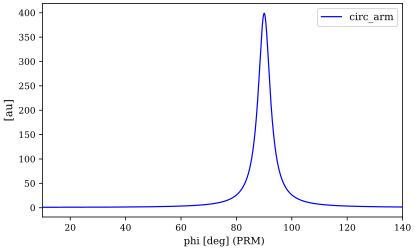

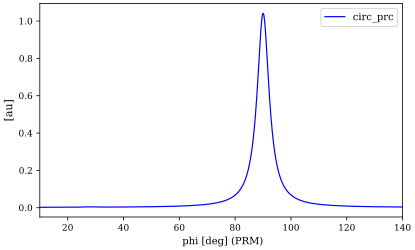

max power arm 398.925858191348
array number [[4925]]
PRM tuning for max power in arm and prc [[90.03125]]


In [4]:
### Tuning check ####

out_dc = kat_dc.run()
out_dc.info()
out_dc.plot(['circ_arm'])
out_dc.plot(['circ_prc'])
print("max power arm",max(out_dc['circ_arm']))
print("array number",np.argwhere(out_dc['circ_arm'] == max(out_dc['circ_arm'])))
print("PRM tuning for max power in arm and prc",out_dc.x[np.argwhere(out_dc['circ_arm'] == max(out_dc['circ_arm']))])


### SET PRM phi ###
kat.PRM.phi = out_dc.x[np.argwhere(out_dc['circ_arm'] == max(out_dc['circ_arm']))]


In [5]:
#### POP & REFL RF PDs #####

kat_pd1s = kat.deepcopy()
kat_pd1s.parse(""" 


const sb1 55.556M
const sb2 111.112M
const sb3 166.668M 

pd2 pop_I $sb1 60 10 0 bs21tr                # POP I  1f
pd2 pop_Q $sb1 70 10 0 bs21tr               # POP Q  1f
pd2 pop_I_f2 $sb2 0 10 0 bs21tr            # POP I  3f
pd2 pop_Q_f2 $sb2 90 10 0 bs21tr           # POP Q  3f
pd2 pop_I_f3 $sb3 0 10 0 bs21tr            # POP I  3f
pd2 pop_Q_f3 $sb3 90 10 0 bs21tr           # POP Q  3f


pd2 refl_I $sb1 0 10 0 refl              # REFL I  1f
pd2 refl_Q $sb1 90 10 0 refl             # REFL Q  1f
pd2 refl_I_f2 $sb2 0 10 0 refl          # REFL I  3f
pd2 refl_Q_f2 $sb2 90 10 0 refl         # REFL Q  3f
pd2 refl_I_f3 $sb3 0 10 0 refl          # REFL I  3f
pd2 refl_Q_f3 $sb3 90 10 0 refl         # REFL Q  3f

pd circ_arm b5
pd circ_prc pop
pd refl refl
pd trans b6


#xaxis sig1 f log .01 100 8000

put refl_I f2 $x1
put refl_Q f2 $x1
put refl_I_f2 f2 $x1
put refl_Q_f2 f2 $x1
put refl_I_f3 f2 $x1
put refl_Q_f3 f2 $x1

put pop_I f2 $x1
put pop_Q f2 $x1
put pop_I_f2 f2 $x1
put pop_Q_f2 f2 $x1
put pop_I_f3 f2 $x1
put pop_Q_f3 f2 $x1



#scale deg

""")


Finesse variable `$x1` does not exist.


Parsing `put refl_I f2 $x1` into pykat object not implemented
yet, added as extra line.


Finesse variable `$x1` does not exist.


Parsing `put refl_Q f2 $x1` into pykat object not implemented
yet, added as extra line.


Finesse variable `$x1` does not exist.


Parsing `put refl_I_f2 f2 $x1` into pykat object not
implemented yet, added as extra line.


Finesse variable `$x1` does not exist.


Parsing `put refl_Q_f2 f2 $x1` into pykat object not
implemented yet, added as extra line.


Finesse variable `$x1` does not exist.


Parsing `put refl_I_f3 f2 $x1` into pykat object not
implemented yet, added as extra line.


Finesse variable `$x1` does not exist.


Parsing `put refl_Q_f3 f2 $x1` into pykat object not
implemented yet, added as extra line.


Finesse variable `$x1` does not exist.


Parsing `put pop_I f2 $x1` into pykat object not implemented
yet, added as extra line.


Finesse variable `$x1` does not exist.


Parsing `put pop_Q f2 $x1` int

<h2>LSC using Decoupling Slope Method</h2>

--------------------------------------------------------------
Running kat - Started at 2022-12-07 19:47:56.156828


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse None at C:\Users\Parivesh\anaconda3\Library\bin\kat.exe

Finished in 5.96962 seconds


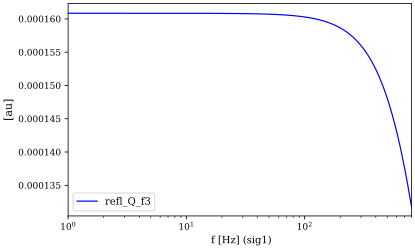

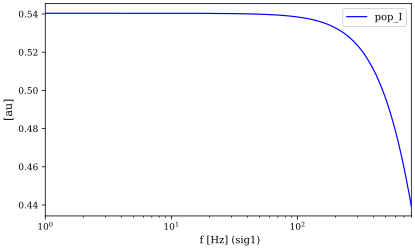

--------------------------------------------------------------
Running kat - Started at 2022-12-07 19:48:03.206344


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse None at C:\Users\Parivesh\anaconda3\Library\bin\kat.exe

Finished in 6.0112 seconds


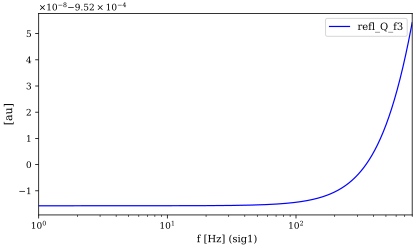

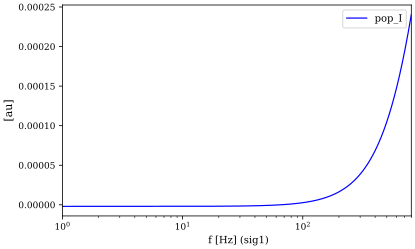

+-------------------------------------------------------------+
|                PRM/ETM tune Decoupling Method               |
+--------------+-----------------------+----------------------+
| SIGNAL V/rad |          PRCL         |         ARM          |
+--------------+-----------------------+----------------------+
|   pop_I_1f   | -1.97191808757891e-06 |  0.540386916614082   |
|  refl_Q_3f   | -0.000952015724551771 | 0.000160848200852697 |
+--------------+-----------------------+----------------------+


In [6]:
#### PRM/ARM tune Decoupling Method ###
#### measure tf using fsig same as PDH error slope ####

ETM_tun = kat_pd1s.deepcopy()
ETM_tun.parse("""
fsig sig1 ETM 10 0
xaxis sig1 f log 1 800 800
""")
ETM_tun.refl_Q_f3.phase1 = 46.256983240           #### set optimum phases #### 
ETM_tun.pop_I.phase1 = 166.927374301676
out_etm = ETM_tun.run()
out_etm.plot(['refl_Q_f3'])
out_etm.plot(['pop_I'])

PRM_tun = kat_pd1s.deepcopy()
PRM_tun.parse("""
fsig sig1 PRM 10 0
xaxis sig1 f log 1 800 800
""")
PRM_tun.refl_Q_f3.phase1 = 46.256983240
PRM_tun.pop_I.phase1 = 166.927374301676
out_prm = PRM_tun.run()
out_prm.plot(['refl_Q_f3'])
out_prm.plot(['pop_I'])


#### print matrix ####

from prettytable import PrettyTable

t = PrettyTable(['SIGNAL V/rad','PRCL','ARM'])
t.add_row(['pop_I_1f',out_prm['pop_I'][1], out_etm['pop_I'][1]])               
t.add_row(['refl_Q_3f',out_prm['refl_Q_f3'][1],out_etm['refl_Q_f3'][1]])
t.title = 'PRM/ETM tune Decoupling Method'
print(t)


<h2>LSC using Maximum Slope Method</h2>

In [7]:
#### PRM/ARM tune Slope Method ###

ETM_tun = kat_pd1s.deepcopy()
ETM_tun.parse("""
fsig sig1 ETM 10 0
xaxis sig1 f log 1 800 800
""")

ETM_tun.pop_I.phase1 = 59.32960894
#ETM_tun.refl_Q_f3.phase1 = 166.85370741
ETM_tun.refl_Q_f3.phase1 = 163.91061453
out_etm = ETM_tun.run()


PRM_tun = kat_pd1s.deepcopy()
PRM_tun.parse("""
fsig sig1 PRM 10 0
xaxis sig1 f log 1 800 800
""")

PRM_tun.pop_I.phase1 = 59.32960894
#PRM_tun.refl_Q_f3.phase1 = 166.85370741+90
PRM_tun.refl_Q_f3.phase1 = 163.91061453

out_prm = PRM_tun.run()


from prettytable import PrettyTable

t = PrettyTable(['SIGNAL V/rad','PRCL','ARM'])
t.add_row(['pop_I_1f',out_prm['pop_I'][1], out_etm['pop_I'][1]])                   
t.add_row(['refl_Q_3f',out_prm['refl_Q_f3'][0],out_etm['refl_Q_f3'][1]])


t.title = 'PRM/ETM tune Slope Method'
print(t)


--------------------------------------------------------------
Running kat - Started at 2022-12-07 19:48:10.519193


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse None at C:\Users\Parivesh\anaconda3\Library\bin\kat.exe

Finished in 6.06721 seconds
--------------------------------------------------------------
Running kat - Started at 2022-12-07 19:48:16.611385


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse None at C:\Users\Parivesh\anaconda3\Library\bin\kat.exe

Finished in 5.80479 seconds
+------------------------------------------------------------+
|                 PRM/ETM tune Slope Method                  |
+--------------+-----------------------+---------------------+
| SIGNAL V/rad |          PRCL         |         ARM         |
+--------------+-----------------------+---------------------+
|   pop_I_1f   | -0.000819633887271368 |  -1.77672754869903  |
|  refl_Q_3f   |  0.00205996944263719  | -0.0721320454759479 |
+--------------+-----------------------+---------------------+


<h2>ASC</h2>

In [8]:
############ Angular sensing ########

kat_qpds = kat.deepcopy()
kat_qpds.parse(""" 



const sb1 55.556M
const sb2 111.112M
const sb3 166.668M 

#### REFL ######

attr sr g 0                                 #guoy phase for det1
attr sQPD1 g 0                                 #guoy phase for det1
attr sQPD2 g 90                                #guoy phase for det2

pd2 REFL_A $sb3 0 1 0 a11                       #Split detector1 refl
pdtype REFL_A x-split   
pd2 REFL_B $sb3 90 1 0 a12                       #Split detector2 refl
pdtype REFL_B x-split  

#put REFL_A f2 $x1
#put REFL_B f2 $x1




#### POP ######

#attr s21 g 0                                 #guoy phase for det1
attr sQPD11 g 0                                 #guoy phase for det1
attr sQPD21 g 90                                #guoy phase for det2

pd2 POP_A $sb1 0 1 0 a11a                       #Split detector1 refl
pdtype POP_A x-split   
pd2 POP_B $sb1 90 1 0 a12a                       #Split detector2 refl
pdtype POP_B x-split  

#put POP_A f2 $x1
#put POP_B f2 $x1


""")


<h2>ASC sensing matrix</h2>

In [9]:
ETM_ms = kat_qpds.deepcopy()
ETM_ms.parse("""
fsig sig1 ETM xbeta 1 0 1
fsig sig2 ITM xbeta 1 0 1

""")
ETM_ms.sQPD11.gouy = 280           #### set optimum gouy phase --> such that slope of POP/REFL_A and POP/REFL_B are orthogonal #####
ETM_ms.sQPD21.gouy = 370
ETM_ms.noxaxis = True
ETM_ms_out = ETM_ms.run()
ETM_ms_out.info()


ITM_ms = kat_qpds.deepcopy()
ITM_ms.parse("""
fsig sig1 ETM xbeta 1 0 -1
fsig sig2 ITM xbeta 1 0 1
""")
ITM_ms.sQPD11.gouy = 280
ITM_ms.sQPD21.gouy = 370
ITM_ms.noxaxis = True
ITM_ms_out = ITM_ms.run()
ITM_ms_out.info()


PRM_ms = kat_qpds.deepcopy()
PRM_ms.parse("""
fsig sig1 PRM xbeta 1 0 1
""")
PRM_ms.sQPD1.gouy = 185
PRM_ms.sQPD2.gouy = 275
PRM_ms.noxaxis = True
PRM_ms_out = PRM_ms.run()
PRM_ms_out.info()



--------------------------------------------------------------
Running kat - Started at 2022-12-07 19:48:22.586268
Used Finesse None at C:\Users\Parivesh\anaconda3\Library\bin\kat.exe

Finished in 0.139866 seconds

--- Output info ---

Run date and time: 2022-12-07 19:48:22.586267
Detectors used: POP_A, POP_B, REFL_A, REFL_B

No xaxis used
REFL_A : min = -3.145435499902930e-06 max = -3.145435499902930e-06
REFL_B : min = -1.874146984285150e-05 max = -1.874146984285150e-05
POP_A  : min = 2.842827799927940e-01 max = 2.842827799927940e-01
POP_B  : min = 8.128349188457711e-02 max = 8.128349188457711e-02
--------------------------------------------------------------
Running kat - Started at 2022-12-07 19:48:22.756642


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse None at C:\Users\Parivesh\anaconda3\Library\bin\kat.exe

Finished in 0.13109 seconds

--- Output info ---

Run date and time: 2022-12-07 19:48:22.756642
Detectors used: POP_A, POP_B, REFL_A, REFL_B

No xaxis used
REFL_A : min = -4.642156476859390e-06 max = -4.642156476859390e-06
REFL_B : min = -1.854557390905640e-05 max = -1.854557390905640e-05
POP_A  : min = 6.232940740267850e-01 max = 6.232940740267850e-01
POP_B  : min = 4.992796448636030e-01 max = 4.992796448636030e-01
--------------------------------------------------------------
Running kat - Started at 2022-12-07 19:48:22.912737
Used Finesse None at C:\Users\Parivesh\anaconda3\Library\bin\kat.exe

Finished in 0.133543 seconds

--- Output info ---

Run date and time: 2022-12-07 19:48:22.912736
Detectors used: POP_A, POP_B, REFL_A, REFL_B

No xaxis used
REFL_A : min = -1.222446973773700e-05 max = -1.222446973773700e-05
REFL_B : min = -1.910229732460470e-05 max = -1.910229732460470e-05
POP_A  : min = -6.379327954927180e

100% | ETA:  0:00:00 | Calculating                                             

In [10]:
from prettytable import PrettyTable

t = PrettyTable(['SIGNAL V/rad','ITM','ETM','PRM'])
t.add_row(['POP_A',ITM_ms_out['POP_A']/1235.41354599557,ETM_ms_out['POP_A']/1235.41354599557,PRM_ms_out['POP_A']/1235.41354599557])                    ###### Normalised using maximum slope value ########
t.add_row(['POP_B',ITM_ms_out['POP_B']/1235.41354599557,ETM_ms_out['POP_B']/1235.41354599557,PRM_ms_out['POP_B']/1235.41354599557])
t.add_row(['REFL_A',ITM_ms_out['REFL_A']/0.0210134811167242,ETM_ms_out['REFL_A']/0.0210134811167242,PRM_ms_out['REFL_A']/0.0210134811167242])
t.add_row(['REFL_B',ITM_ms_out['REFL_B']/0.0210134811167242,ETM_ms_out['REFL_B']/0.0210134811167242,PRM_ms_out['REFL_B']/0.0210134811167242])
t.title = 'ITM/ETM/PRM Misalignment'
print(t)

a = ITM_ms_out['POP_A']/1235.41354599557
b = ETM_ms_out['POP_A']/1235.41354599557
c = PRM_ms_out['POP_A']/1235.41354599557
d = ITM_ms_out['POP_B']/1235.41354599557
e = ETM_ms_out['POP_B']/1235.41354599557
f = PRM_ms_out['POP_B']/1235.41354599557
g = ITM_ms_out['REFL_A']/0.0210134811167242
h = ETM_ms_out['REFL_A']/0.0210134811167242
i = PRM_ms_out['REFL_A']/0.0210134811167242

+-------------------------------------------------------------------------------------------+
|                                  ITM/ETM/PRM Misalignment                                 |
+--------------+-------------------------+-------------------------+------------------------+
| SIGNAL V/rad |           ITM           |           ETM           |          PRM           |
+--------------+-------------------------+-------------------------+------------------------+
|    POP_A     |  0.0005045226159670262  |  0.00023011143184746444 | -5.163718639483054e-05 |
|    POP_B     |  0.00040413968786561557 |   6.5794560977615e-05   | -0.0010625232950914696 |
|    REFL_A    | -0.00022091325330979037 | -0.00014968655038310346 | -0.0005817441512823782 |
|    REFL_B    |  -0.0008825560032647973 |  -0.0008918783964802265 | -0.0009090496343036457 |
+--------------+-------------------------+-------------------------+------------------------+


<h2>Diagonalsiation using row operations</h2>

In [11]:
#M1 = np.array([[ITM_ms_out['POP_A'],ETM_ms_out['POP_A'],PRM_ms_out['POP_A']], [ITM_ms_out['POP_B'],ETM_ms_out['POP_B'],PRM_ms_out['POP_B']], [ITM_ms_out['REFL_A'],ETM_ms_out['REFL_A'],PRM_ms_out['REFL_A']]])
#print(M1)


###### diagonalisation using row operations ######### 
###### REFL_B not used because only 3 degrees of freedom ######


M1 = np.array([[a,b,c], [d,e,f], [g,h,i]])
print(M1)

A = np.array([[e, h], [f, i]])
B = np.array([b, c])
X1 = np.linalg.solve(A,B)

print(X1)

a = a - d*X1[0] - g*X1[1]
b = b - e*X1[0] - h*X1[1]
c = c - f*X1[0] - i*X1[1]
M1 = np.array([[a,b,c], [d,e,f], [g,h,i]])
print(M1)



A = np.array([[a, g], [c, i]])
B = np.array([d, f])
X2 = np.linalg.solve(A,B)

print(X2)

e = e - b*X2[0] - h*X2[1]
d = d - a*X2[0] - g*X2[1]
f = f - c*X2[0] - i*X2[1]
M1 = np.array([[a,b,c], [d,e,f], [g,h,i]])
print(M1)

A = np.array([[a, d], [b, e]])
B = np.array([g, h])
X3 = np.linalg.solve(A,B)

print(X3)

i = i - c*X3[0] - f*X3[1]
g = g - a*X3[0] - d*X3[1]
h = h - b*X3[0] - e*X3[1]
M1 = np.array([[a,b,c], [d,e,f], [g,h,i]])
print(M1)




#### print diagonal matrix #######


from prettytable import PrettyTable

t = PrettyTable(['Combination of SIGNAL V/rad','Soft mode','Hard mode','PRM'])
t.add_row(["(POP_A)+"+str(round(X1[0],3))+"(POP_B)+"+str(round(X1[1],3))+"(REFL_A)",a,b,c])                    ###### Normalised using maximum slope value ########
t.add_row(["(POP_B)+"+str(round(X2[0],3))+"(POP_A)+"+str(round(X2[1],3))+"(REFL_A)",d,e,f])
t.add_row(["(REFL_A)+"+str(round(X3[0],3))+"(POP_A)+"+str(round(X3[1],3))+"(POP_B)",g,h,i])

t.title = 'RM/hard/soft Misalignment'
print(t)



[[ 5.04522616e-04  2.30111432e-04 -5.16371864e-05]
 [ 4.04139688e-04  6.57945610e-05 -1.06252330e-03]
 [-2.20913253e-04 -1.49686550e-04 -5.81744151e-04]]
[ 0.71758879 -1.22187325]
[[-5.54114894e-05 -2.71050543e-20  0.00000000e+00]
 [ 4.04139688e-04  6.57945610e-05 -1.06252330e-03]
 [-2.20913253e-04 -1.49686550e-04 -5.81744151e-04]]
[-14.57505386   1.82644431]
[[-5.54114894e-05 -2.71050543e-20  0.00000000e+00]
 [ 0.00000000e+00  3.39188709e-04  0.00000000e+00]
 [-2.20913253e-04 -1.49686550e-04 -5.81744151e-04]]
[ 3.98677703 -0.44130759]
[[-5.54114894e-05 -2.71050543e-20  0.00000000e+00]
 [ 0.00000000e+00  3.39188709e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -5.81744151e-04]]
+------------------------------------------------------------------------------------------------------------------+
|                                            RM/hard/soft Misalignment                                             |
+--------------------------------------+-------------------------+----

In [12]:
print(max(out_prm['pop_I']))

-0.000819633861460398
